# SBM as a Connectivity Kernel: From Continuous to Categorical Dimensions

## Using MCMC for "Generative" Bayesian Inference

Recall the generative model which employs an exponential kernel in the CDF-transformed $y=F_X(x)$ space. While putting a Gaussian Process prior on $\theta$ is "Bayesian" in the sense that it updates our belief about $\theta$ after observing the data (proportion of friends within window $w$ for all $x_i$), it doesn't follow the actual probabilistic generative model. Here, we employ a deep probabilistic model, and perform Hamiltonian Monte Carlo to sample $\theta$ from its "true" posterior distribution. Let us import the relevant modules and rewrite the data generation and window querying functions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tfp.positive_semidefinite_kernels
ed2 = tfp.edward2

In [15]:
def generate_data(n=1000, theta=0, omega=10, rate=None):
    import numpy as np
    x = np.random.random(n)
    x.sort()
    omega /= n
    if theta!=0: exp_phi = (omega*theta/2)/((np.exp(theta)-1)/theta-1)
    else: exp_phi = omega
    def probs(x):
        p = list()
        for i in x:
            p.append(np.exp(theta*np.abs(x-i))*exp_phi)
        p = np.vstack(p)
        np.fill_diagonal(p, 0)
        p[p>1] = 1.
        return p
    p = probs(x)
    net = np.triu(np.random.binomial(1, p))
    net = np.array(net+np.transpose(net), dtype=bool)
    print('mean degree:', np.mean(np.sum(net, axis=1)))
    if rate is not None:
        x = (-1.0/rate)*np.log(1-x)
        #dist = sns.kdeplot(x, shade=True)
    return {'x':x, 'p':p, 'net':net, 'theta':theta, 'omega':omega, 'rate':rate}

In [3]:
def query_friends(data, w, bootstrap=False, collapse=True):
    import numpy as np
    if not hasattr(w, '__iter__'): w = [w]
    x = data['x']
    w = [w_i*(max(x)-min(x)) for w_i in w]
    net = data['net']
    n = x.size
    w_prop = np.zeros([len(w), n])
    if bootstrap: idx = np.random.choice(n, n)
    else: idx = range(n)
    k = 0
    for i in idx:
        x_friends = x[net[i]]
        for j in range(len(w)):
            w_prop[j][k] = np.sum(np.abs(x_friends-x[i])<=w[j])/np.size(x_friends)
        k += 1
    if collapse: return np.nanmean(w_prop, axis=1)
    else: return w_prop, x[idx]

In [4]:
def mimic_distribution(data, gaussian_bw=None):
    from scipy import stats
    data = data.copy()
    data.sort()
    kernel = stats.gaussian_kde(data, gaussian_bw)
    norm = kernel.integrate_box_1d(data[0], data[-1])
    
    class kernel_distribution(stats.rv_continuous):
        def _pdf(self, x):
            if hasattr(x, '__iter__'):
                output = list()
                for x_i in x:
                    if data[0] <= x_i <= data[-1]: output.append(kernel.evaluate([[x_i]])[0]/norm)
                    else: output.append(0.0)
                return output
            else:
                if data[0] <= x <= data[-1]: return kernel.evaluate([[x]])[0]/norm
                else: return 0.0
        def _cdf(self, x):
            if hasattr(x, '__iter__'):
                output = list()
                for x_i in x:
                    if data[0] < x_i < data[-1]: output.append(kernel.integrate_box_1d(data[0], x_i)/norm)
                    elif x_i <= data[0]: output.append(0.0)
                    else: output.append(1.0)
                return output
            else:
                if data[0] < x < data[-1]: return kernel.integrate_box_1d(data[0], x)/norm
                elif x <= data[0]: return 0.0
                else: return 1.0
        def support(self):
            return (data[0], data[-1])
    
    return kernel_distribution(name='empirical_distribution')

Now we query for every point $y_i$ separately for its number of friends, using equation 17, given $\theta$ (``c`` below). Note that as was the case when doing Gaussian Process Regression, we do not have to integrate over $y$ from $0$ to $1$.

In [5]:
def pfunc_given_w_x(data, w, use_tf=False):
    x_dist = mimic_distribution(data['x'])
    x_a, x_b = x_dist.support()
    w *= (x_b-x_a)
    y = x_dist.cdf(data['x'])
    y_ll, y_ul = x_dist.cdf(x_a+w), x_dist.cdf(x_b-w)
    
    if use_tf: from tensorflow import exp, equal, cond, constant, float32
    else:
        from math import exp
        def equal(a, b):
            return a==b
        def cond(x, a, b):
            if x: return a()
            else: return b()
        def constant(x, dtype):
            return x
        float32 = None
    
    # equation 17
    def f_lower(c, y, i):
        return cond(equal(c, 0),
                    lambda: constant(x_dist.cdf(x_dist.ppf(y)+w) + i, dtype=float32),
                    lambda: (exp(c*y) + exp(c*(x_dist.cdf(x_dist.ppf(y)+w)-y)) - 2) / (exp(c*y) + exp(c*(1-y)) - 2) + i)
    def f_middle(c, y, i):
        return cond(equal(c, 0), 
                    lambda: constant(x_dist.cdf(x_dist.ppf(y)+w) - x_dist.cdf(x_dist.ppf(y)-w) + i, dtype=float32),
                    lambda: (exp(c*(y-x_dist.cdf(x_dist.ppf(y)-w))) + exp(c*(x_dist.cdf(x_dist.ppf(y)+w)-y)) - 2) / (exp(c*y) + exp(c*(1-y)) - 2) + i)
    def f_upper(c, y, i):
        return cond(equal(c, 0),
                    lambda: constant(1 - x_dist.cdf(x_dist.ppf(y)-w) + i, dtype=float32),
                    lambda: (exp(c*(y-x_dist.cdf(x_dist.ppf(y)-w))) + exp(c*(1-y)) - 2) / (exp(c*y) + exp(c*(1-y)) - 2) + i)
    
    funcs = list()
    if y_ul>y_ll:
        for y_i in y:
            if y_i<=y_ll: funcs.append(f_lower)
            elif y_i>=y_ul: funcs.append(f_upper)
            else: funcs.append(f_middle)
    else:
        for y_i in y:
            if y_i<=y_ul: funcs.append(f_lower)
            elif y_i>=y_ll: funcs.append(f_upper)
            else: funcs.append(lambda c, y, i: constant(1.0 + i, dtype=float32))
    return y, funcs

We now describe the probabilistic kernel. Recall that earlier, we had:

$$P(a_{ij}=1|x_i, x_j) \propto \exp(\theta|F_X(x_i)-F_X(x_j)|)$$

If $p(w, x_i)$ be the proportion of friends of $i$ within a window $w$ in the space $X$ (the output of ``query_friends()``), then we can expect this to be a random variable itself. Specifically, let this follow a Beta distribution, whose mean is given by the value *expected* at $x_i$ (the output of ``pfunc_given_w_x()``). The variance of this distribution can be assumed fixed, but we treat it as a random variable itself (since we've observed different amounts of error in the GPR model given different $\theta$). In all, we can have the following deep probabilistic model:

$$\theta \sim \mathrm{Cauchy}(0,5)$$
$$\nu \sim \mathrm{Gamma}(2,1)$$
$$p(w, x_i) \sim \mathrm{Beta}\left(\mathrm{pfunc}(w, x_i, \theta)*\nu, (1-\mathrm{pfunc}(w, x_i, \theta))*\nu\right)$$

A few things to note:

1. We have put a very broad prior on $\theta$ to allow for extreme values (the IQR of Cauchy is 2Xscale, which gives an IQR of -5 to 5 here).
2. $\nu = \alpha+\beta$ is the total concentration of the Beta distribution, which controls the variance and thus whether the distribution is U-shaped or inverse-U-shaped, given the mean $p=\frac{\alpha}{\alpha+\beta}$ (since $p\nu<1$ & $(1-p)\nu<1$ for U-shaped and vice-versa). Effectively, larger $\nu$ means loer variance. Note that we keep the same $\nu$ regardless of $x_i$, and it follows a Gamma distribution whose mode is $1$ and mean is $2$, to absorb the fact that we have exactly one sample corresponding to $i$ from this Beta distribution.
3. For a Beta distribution we must ensure $\alpha>0, \beta>0$, and that its support excludes $0, 1$. Thus, we have to employ a small tolerance value, such as ``1e-5``, to ensure this. Otherwise the log probability can be $\pm\infty$, which will prevent us from performing HMC.

In [6]:
def deep_probabilistic_kernel(data, w, tol=1e-5):
    rv_theta = ed2.Cauchy(loc=0., scale=5.0, name='rv_theta') #I.Q.R. for Cauchy is 2*scale
    rv_conc = ed2.Gamma(concentration=2., rate=1., name='rv_conc') #controls the variance of Beta distribution
    y, pfuncs = pfunc_given_w_x(data, w, use_tf=True)
    p = tf.stack([pfuncs[i](rv_theta, y[i], tol) for i in range(len(data['x']))]) #small tolerance so that alpha>0
    rv_prop = ed2.Beta(concentration1=p*rv_conc, concentration0=(1.-p)*rv_conc, name='rv_prop')
    return {'theta':rv_theta, 
            'conc':rv_conc,
            'prop':rv_prop}

For HMC inference, we need to take care of chooding the right number of leapfrog steps $n$ and the step size $\epsilon$, which affect discretization error of the Hamiltonian. The total trajectory length before taking the next sample is $l=n\epsilon$. We choose a large number of steps $n=100$ and a length of $l=0.5$, which should efficiently and accurately sample the space of $\theta$ and $\nu$ with the effective step size of $\epsilon=0.005$. We run the HMC for 100 samples (ideally a larger number, say thousands).

Also note that we fix the query window at $w=0.1$ for experiments below.

In [7]:
def infer_theta_hmc(data, w=0.1, tol=1e-5, len_trajectory=0.5, num_steps=100, num_samples=100, num_warmup=10):
    import numpy as np
    p_data, x = query_friends(data, w, collapse=False)
    p_data[0][p_data[0]<=tol] = tol #clipping to prevent log_prob==+/-inf for Beta distribution
    p_data[0][p_data[0]>=1-tol] = 1.-tol #clipping to prevent log_prob==+/-inf for Beta distribution
    p_data = tf.constant(p_data[0], dtype=np.float32)
    theta = tf.constant(0.0, dtype=np.float32)
    conc = tf.constant(1.0, dtype=np.float32)
    initial_state = [theta, conc]
    log_joint = ed2.make_log_joint_fn(deep_probabilistic_kernel)
    
    def log_cond(theta, conc):
        return log_joint(data, w, tol, rv_theta=theta, rv_conc=conc, rv_prop=p_data)
    
    hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=log_cond, 
                                         num_leapfrog_steps=num_steps, 
                                         step_size=len_trajectory/num_steps)

    mcmc_samples, theta_results = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_warmup,
        current_state=initial_state,
        kernel=hmc)
    acceptance_rate = tf.reduce_mean(tf.to_float(theta_results.is_accepted))
    theta_mean = tf.reduce_mean(mcmc_samples[0], axis=0)
    conc_mean = tf.reduce_mean(mcmc_samples[1], axis=0)
    theta_proposed = theta_results.proposed_state[0]
    conc_proposed = theta_results.proposed_state[1]
    loglike_proposed = theta_results.proposed_results.target_log_prob
    loglike_grad_theta_proposed = theta_results.proposed_results.grads_target_log_prob[0]
    loglike_grad_conc_proposed = theta_results.proposed_results.grads_target_log_prob[1]
    with tf.Session() as sess:
        [acceptance_rate, 
         theta_mean, 
         conc_mean,  
         theta_samples, 
         conc_samples, 
         theta_proposed, 
         conc_proposed, 
         loglike_proposed,
         loglike_grad_theta_proposed, 
         loglike_grad_conc_proposed] = sess.run([acceptance_rate, 
                                                 theta_mean,
                                                 conc_mean, 
                                                 mcmc_samples[0], 
                                                 mcmc_samples[1], 
                                                 theta_proposed, 
                                                 conc_proposed, 
                                                 loglike_proposed,
                                                 loglike_grad_theta_proposed, 
                                                 loglike_grad_conc_proposed])
    
    print('acceptance rate:', acceptance_rate)
    print('mean theta:', theta_mean)
    print('mean conc:', conc_mean)
  
    try:
        from scipy.stats import gaussian_kde
        for(i, j) in [(theta_samples, 'theta'), (conc_samples, 'conc')]:
            density = gaussian_kde(i)
            xs = np.linspace(min(i), max(i), 100)
            plt.plot(xs, density(xs))
            try:
                plt.gca().axvline(data[j], ls='--')
            except:
                pass
            plt.title('Posterior of '+j)
            plt.show()
    except:
        pass
    return (theta_samples, 
            conc_samples, 
            theta_proposed, 
            conc_proposed, 
            loglike_proposed, 
            loglike_grad_theta_proposed, 
            loglike_grad_conc_proposed, 
            theta_results)

We generate a strongly homophilic dataset with $\theta=-10$ and infer $\theta$ by HMC.

In [8]:
y_ho_uni = generate_data(theta=-10)

mean degree: 10.09


/rds/general/user/sl2416/home/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/rds/general/user/sl2416/home/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


acceptance rate: 1.0
mean theta: -10.449634
mean conc: 2.7558703


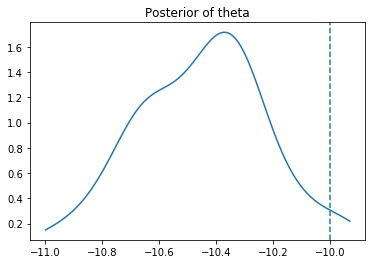

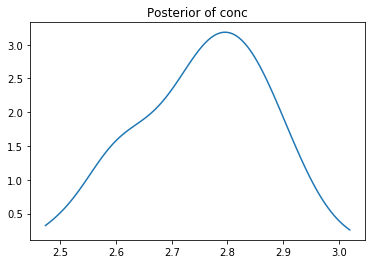

In [9]:
results = infer_theta_hmc(y_ho_uni)

We obtain a fairly tight distribution around -10. We repeat the inference for mild heterophily $\theta=2$.

In [10]:
y_he_uni = generate_data(theta=2)

mean degree: 10.098


acceptance rate: 1.0
mean theta: 1.8182422
mean conc: 2.1184084


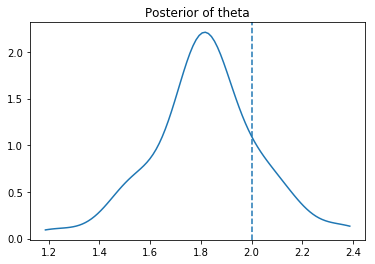

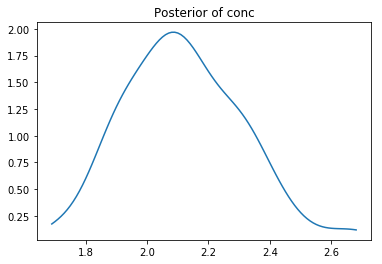

In [11]:
results_he_uni = infer_theta_hmc(y_he_uni)

Again, we obtain fair estimates for $\theta$. Now using the exponentially distributed population, with a milder homophily of $\theta=-5$.

In [16]:
y_ho_exp = generate_data(theta=-5, rate=4)

mean degree: 10.032


In [24]:
y_ho_exp = generate_data(theta=-10, rate=4)

mean degree: 10.008


In [ ]:
results_ho_exp = infer_theta_hmc(y_ho_exp)

/rds/general/user/sl2416/home/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
/rds/general/user/sl2416/home/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.
/rds/general/user/sl2416/home/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


Interestingly, although the mean of posterior samples is close to the original, we obtain a broader posterior distribution that shows bimodality in both $\theta$ and $\nu$. One might be curious to know if these two modes correspond for both parameters, which we can confirm below by doing a bivariate plot of the posterior samples.

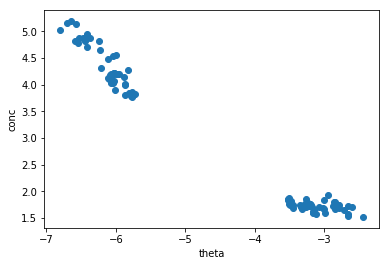

In [23]:
import matplotlib.pyplot as plt
plt.scatter(results_ho_exp[0], results_ho_exp[1])
plt.xlabel('theta')
plt.ylabel('conc')
plt.show()

That is, the data is explained by two sets of parameters: $(\theta,\nu) \approx (-3.0, 1.5)$ and $(\theta,\nu) \approx (-6.5, 4.5)$. One possible explanation is that the former set caters more to the sparse end of the distribution in Blau space (thus having a looser kernel and more variance in $p$), while the latter to the dense end (thus having a tighter kernel and lesser variance in $p$). Now we repeat the same for mild heterophily.

In [18]:
y_he_exp = generate_data(theta=2, rate=4)

mean degree: 9.96


acceptance rate: 1.0
mean theta: 1.6686063
mean conc: 2.6549823


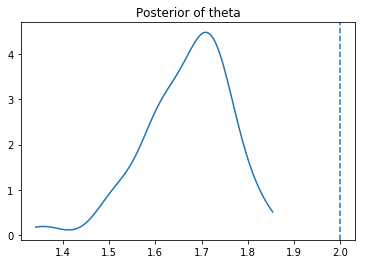

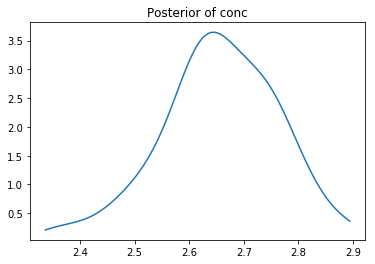

In [19]:
results_he_exp = infer_theta_hmc(y_he_exp)